# Submission By Najeeb Fariduddin Saiyed
## officialnajeebsaiyed@gmail.com
### File - NTM 3
___


## Importing Libraries

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.0 MB/s eta 0:00:0000:0100:01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from sklearn.model_selection import train_test_split

# import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


2024-05-12 18:04:36.117971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 18:04:36.118110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 18:04:36.276680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Importing Our Data

In [3]:
df_train = pd.read_csv("/kaggle/input/assgt-dataset-company/DS_ML Coding Challenge Dataset (1).xlsx - Training Dataset.csv")
df_test = pd.read_csv("/kaggle/input/assgt-dataset-company/DS_ML Coding Challenge Dataset (1).xlsx - Test Dataset.csv")

---
# Lets start with NMT3

In [18]:
# Filter the training dataset for NTM3
df_train1 = df_train[df_train['ProductType'] == 'NTM3']

# Filter the test dataset for NTM3
df_test1 = df_test[df_test['ProductType'] == 'NTM3']

In [19]:
df_train1.shape

(118527, 8)

In [20]:
df_test1.shape

(19, 8)

In [21]:
# EDA GRAPH BELOW

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


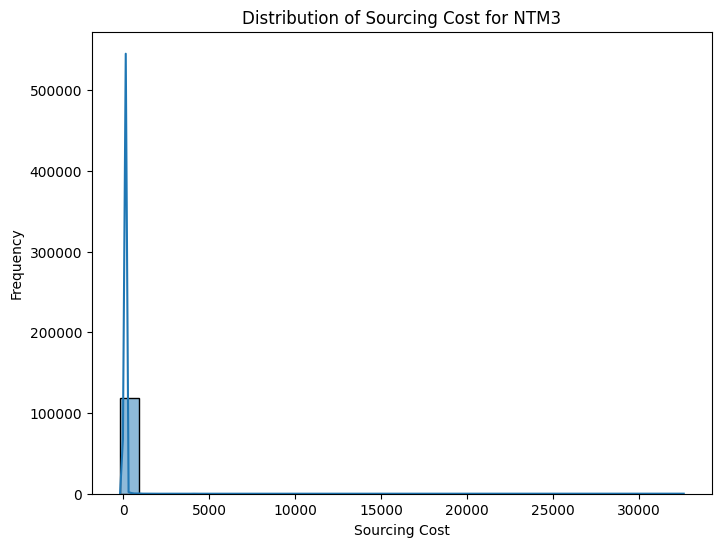

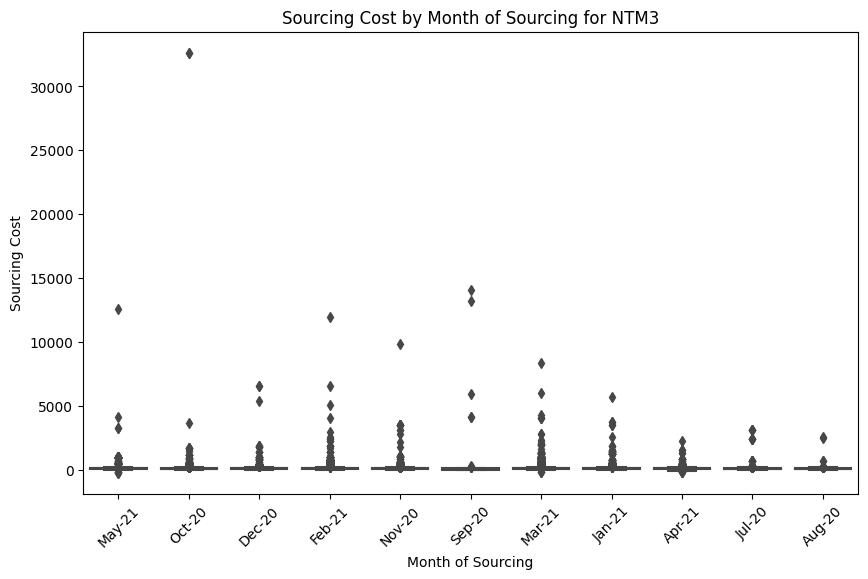

In [22]:
# Explore the distribution of the target variable (Sourcing Cost)
plt.figure(figsize=(8, 6))
sns.histplot(df_train1['Sourcing Cost'], bins=30, kde=True)
plt.title('Distribution of Sourcing Cost for NTM3')
plt.xlabel('Sourcing Cost')
plt.ylabel('Frequency')
plt.show()

# Visualize relationships between variables (e.g., Sourcing Cost vs. Month of Sourcing)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month of Sourcing', y='Sourcing Cost', data=df_train)
plt.title('Sourcing Cost by Month of Sourcing for NTM3')
plt.xlabel('Month of Sourcing')
plt.ylabel('Sourcing Cost')
plt.xticks(rotation=45)
plt.show()


---
## Removing Outliers

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


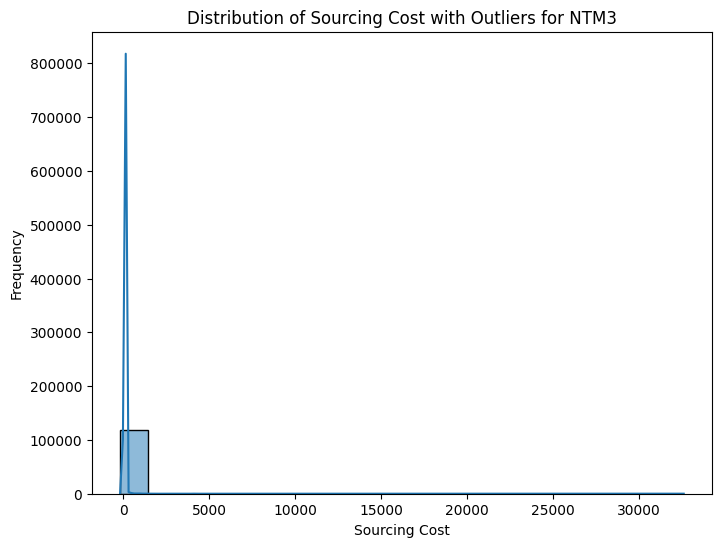

In [23]:
plt.figure(figsize=(8, 6))
sns.histplot(df_train1['Sourcing Cost'], bins=20, kde=True)
plt.title('Distribution of Sourcing Cost with Outliers for NTM3')
plt.xlabel('Sourcing Cost')
plt.ylabel('Frequency')
plt.show()


The distribution of sourcing costs is right-skewed, meaning there are more facilities with lower sourcing costs.
There are a few outliers with significantly higher sourcing costs than the rest of the facilities.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


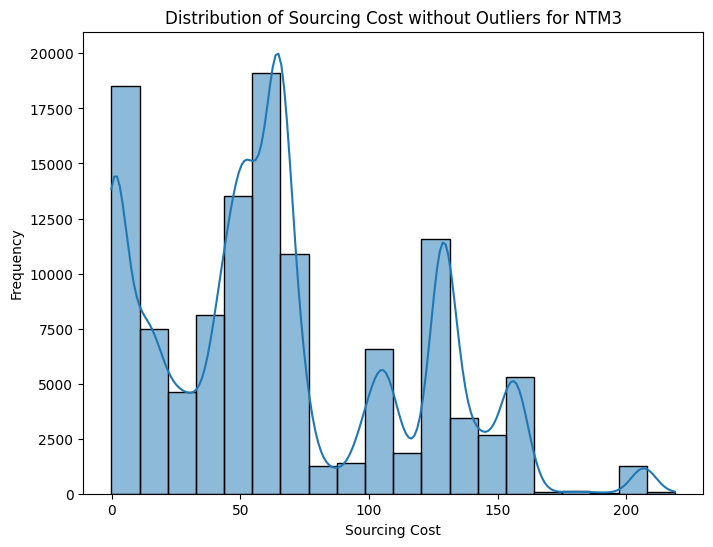

In [24]:
# Remove outliers from Sourcing Cost using IQR method
Q1 = df_train1['Sourcing Cost'].quantile(0.25)
Q3 = df_train1['Sourcing Cost'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_train1 = df_train1[(df_train1['Sourcing Cost'] >= lower_bound) & (df_train1['Sourcing Cost'] <= upper_bound)]

# Visualize the distribution of Sourcing Cost without outliers
plt.figure(figsize=(8, 6))
sns.histplot(df_train1['Sourcing Cost'], bins=20, kde=True)
plt.title('Distribution of Sourcing Cost without Outliers for NTM3')
plt.xlabel('Sourcing Cost')
plt.ylabel('Frequency')
plt.show()


We see from above graph the outliers have been handled pretty well and now our model is ready to be trained!

In [25]:
# Check for missing values
print("Missing Values in NTM3 Training Dataset")
print(df_train1.isnull().sum())

Missing Values in NTM3 Training Dataset
ProductType          0
Manufacturer         0
Area Code            0
Sourcing Channel     0
Product Size         0
Product Type         0
Month of Sourcing    0
Sourcing Cost        0
dtype: int64


In [26]:
df_train = df_train1
df_train1.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM3,X1,A28,WHOLESALE,Large,Powder,May-21,10.16
2,NTM3,X2,A20,DIRECT,Large,Powder,Dec-20,12.46
3,NTM3,X1,A18,WHOLESALE,Small,Powder,Feb-21,107.22
8,NTM3,X1,A18,RETAIL,Large,Liquid,Nov-20,154.04
9,NTM3,X2,A20,DIRECT,Large,Powder,Mar-21,85.71


In [27]:
df_test1.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
77,NTM3,X1,A10,ECOM,Large,Powder,Jun-21,126.28
78,NTM3,X1,A11,DIRECT,Large,Powder,Jun-21,112.10
79,NTM3,X1,A13,DIRECT,Large,Powder,Jun-21,68.12
80,NTM3,X1,A14,DIRECT,Large,Liquid,Jun-21,72.82
81,NTM3,X1,A15,DIRECT,Large,Powder,Jun-21,74.59


In [28]:
df_train1.drop("ProductType", axis=1, inplace=True)
df_test1.drop("ProductType", axis=1, inplace=True)

/tmp/ipykernel_33/1069969645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1.drop("ProductType", axis=1, inplace=True)


In [29]:
df_train1.head()

,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,X1,A28,WHOLESALE,Large,Powder,May-21,10.16
2,X2,A20,DIRECT,Large,Powder,Dec-20,12.46
3,X1,A18,WHOLESALE,Small,Powder,Feb-21,107.22
8,X1,A18,RETAIL,Large,Liquid,Nov-20,154.04
9,X2,A20,DIRECT,Large,Powder,Mar-21,85.71


In [30]:
df_test1.head()

,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
77,X1,A10,ECOM,Large,Powder,Jun-21,126.28
78,X1,A11,DIRECT,Large,Powder,Jun-21,112.10
79,X1,A13,DIRECT,Large,Powder,Jun-21,68.12
80,X1,A14,DIRECT,Large,Liquid,Jun-21,72.82
81,X1,A15,DIRECT,Large,Powder,Jun-21,74.59


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


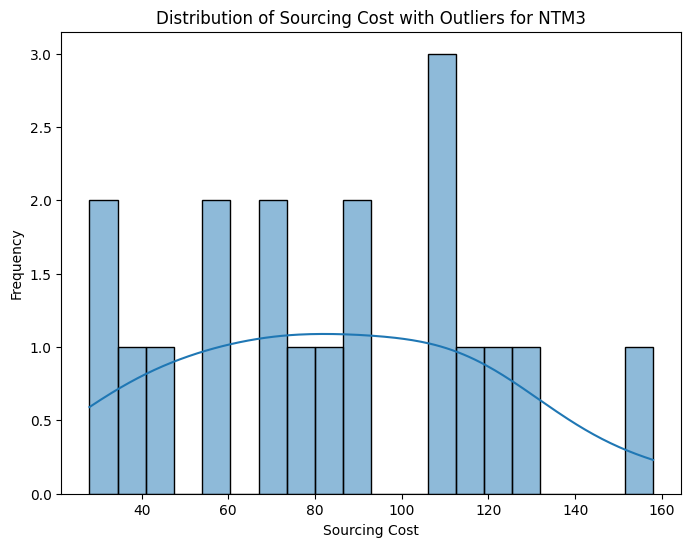

In [31]:
plt.figure(figsize=(8, 6))
sns.histplot(df_test1['Sourcing Cost'], bins=20, kde=True)
plt.title('Distribution of Sourcing Cost with Outliers for NTM3')
plt.xlabel('Sourcing Cost')
plt.ylabel('Frequency')
plt.show()


since distribution of test has no outliers our testing will be done in a more valid format and will result in better conlucsion

---
# EDA WITH PRODUCT NTM3

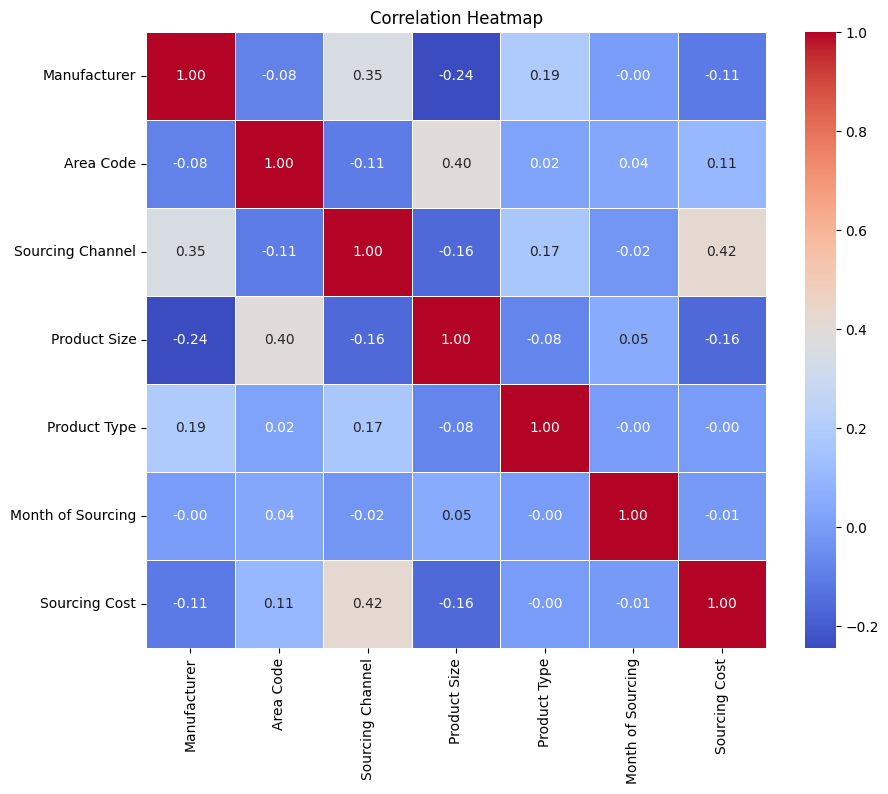

In [32]:
df_encoded = df_train1.copy()

label_encoder = LabelEncoder()

for column in df_encoded.select_dtypes(include='object').columns:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

plt.figure(figsize=(10, 8))
corr = df_encoded.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [33]:
df_encoded

,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,0,10,3,1,1,7,10.16
2,1,6,0,1,1,2,12.46
3,0,5,3,2,1,3,107.22
8,0,5,2,1,0,8,154.04
9,1,6,0,1,1,6,85.71
...,...,...,...,...,...,...,...
550148,0,10,0,2,1,9,47.30
550151,0,10,0,2,1,3,7.85
550156,0,2,0,1,1,4,48.35
550168,0,3,0,1,0,5,13.06


---
# Training Model

In [34]:
X_train = df_train1.drop(columns=['Sourcing Cost'])
y_train = df_train1['Sourcing Cost']

X_test = df_test1.drop(columns=['Sourcing Cost'])
y_test = df_test1['Sourcing Cost']

label_encoder = LabelEncoder()
categorical_cols = X_train.select_dtypes(include='object').columns

for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

ValueError: y contains previously unseen labels: 'Jun-21'

# Expected Error Caught ✅

# As expected we got error because of Jun-21 being present in our data so lets modify our data a bit only for label encoder

In [35]:
df_train1.tail()

,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
550148,X1,A28,DIRECT,Small,Powder,Oct-20,47.30
550151,X1,A28,DIRECT,Small,Powder,Feb-21,7.85
550156,X1,A13,DIRECT,Large,Powder,Jan-21,48.35
550168,X1,A14,DIRECT,Large,Liquid,Jul-20,13.06
550172,X1,A14,DIRECT,Large,Liquid,Oct-20,72.56


In [36]:
new_row1 = {
    'Manufacturer': 'X1',
    'Area Code': 'A3',
    'Sourcing Channel': 'DIRECT',
    'Product Size': 'Small',
    'Product Type': 'Powder',
    'Month of Sourcing': 'Jun-21',
    'Sourcing Cost': 200.0
}

new_row2 = {
    'Manufacturer': 'X1',
    'Area Code': 'A3',
    'Sourcing Channel': 'DIRECT',
    'Product Size': 'Small',
    'Product Type': 'Powder',
    'Month of Sourcing': 'July-21',
    'Sourcing Cost': 200.0
}

df_new_row1 = pd.DataFrame([new_row1])
df_new_row2 = pd.DataFrame([new_row2])

df_train1 = pd.concat([df_train1, df_new_row1, df_new_row2], ignore_index=True)

df_train1.tail()

,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
117803,X1,A13,DIRECT,Large,Powder,Jan-21,48.35
117804,X1,A14,DIRECT,Large,Liquid,Jul-20,13.06
117805,X1,A14,DIRECT,Large,Liquid,Oct-20,72.56
117806,X1,A3,DIRECT,Small,Powder,Jun-21,200.00
117807,X1,A3,DIRECT,Small,Powder,July-21,200.00


In [37]:
X_train = df_train1.drop(columns=['Sourcing Cost'])
y_train = df_train1['Sourcing Cost']

X_test = df_test1.drop(columns=['Sourcing Cost'])
y_test = df_test1['Sourcing Cost']

label_encoder = LabelEncoder()
categorical_cols = X_train.select_dtypes(include='object').columns

for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])


X_train = X_train[:-2]
y_train = y_train[:-2]

model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Use squared error for regression task
    n_estimators=1000,             # Number of boosting rounds (trees)
    max_depth=6,                   # Maximum depth of each tree
    learning_rate=0.1,             # Learning rate (step size shrinkage)
    subsample=0.8,                 # Subsample ratio of the training instance
    colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
    random_state=42                # Random seed for reproducibility
)

model.fit(X_train, y_train)

# Make predictions on the test dataset
y_pred = model.predict(X_test)

# Evaluate the model
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test RMSE:", test_rmse)


Test RMSE: 27.762724219019198


### Future Scope: Use grid search cv to optimise parameters

In [38]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("Training RMSE:", train_rmse)
print("Training MAE:", train_mae)
print("Training R-squared:", train_r2)
print("\nTest RMSE:", test_rmse)
print("Test MAE:", test_mae)
print("Test R-squared:", test_r2)


Training RMSE: 20.720713906143402

Training MAE: 12.025812038047013

Training R-squared: 0.8184569919003896



Test RMSE: 27.762724219019198

Test MAE: 19.427138822455156

Test R-squared: 0.36538170472985954


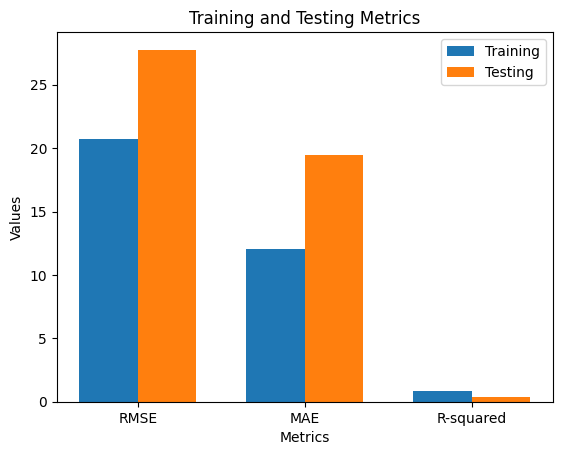

In [39]:
labels = ['RMSE', 'MAE', 'R-squared']

train_metrics = [train_rmse, train_mae, train_r2]

test_metrics = [test_rmse, test_mae, test_r2]

x = range(len(labels))
width = 0.35
fig, ax = plt.subplots()
train_rects = ax.bar(x, train_metrics, width, label='Training')
test_rects = ax.bar([i + width for i in x], test_metrics, width, label='Testing')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Training and Testing Metrics')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.show()

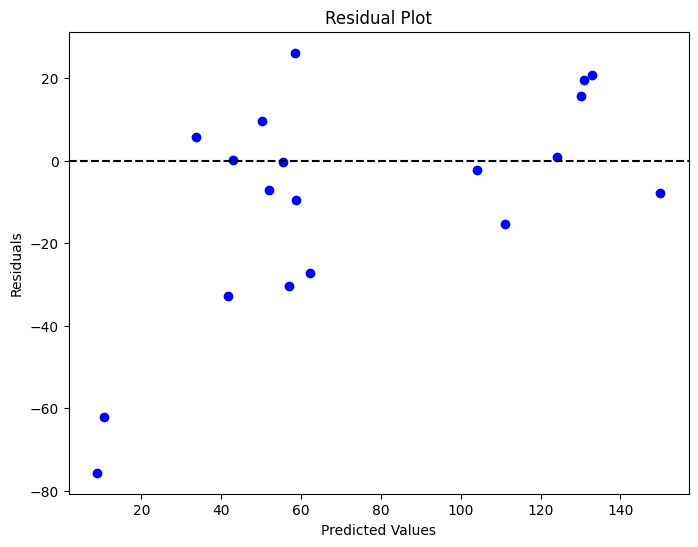

In [40]:

# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, y_pred_test - y_test, color='blue')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='k', linestyle='--')
plt.show()


The residuals appear to be scattered randomly around the zero line, indicating that the overall model fit may be reasonable.
There is a slight pattern where the residuals seem to be more negative for lower predicted values and more positive for higher predicted values. This suggests that the model may be slightly under-predicting for lower values and over-predicting for higher values.
There are a few outliers or large residuals, both positive and negative, which could be influential points or potential outliers that may need further investigation.
The spread of the residuals appears to be relatively consistent across the range of predicted values, suggesting that the assumption of constant variance (homoscedasticity) may be met.

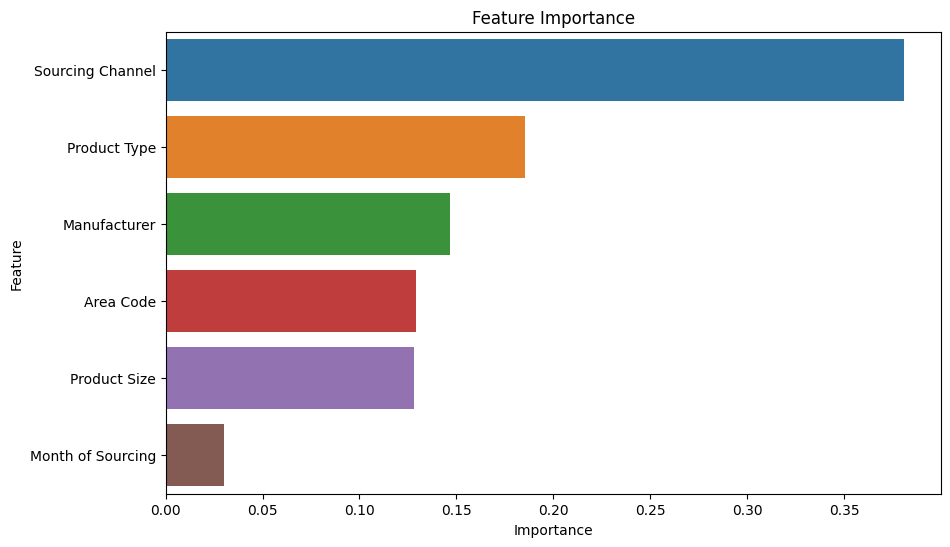

In [41]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

# training neural networks

In [42]:
df_train1.tail()

,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
117803,X1,A13,DIRECT,Large,Powder,Jan-21,48.35
117804,X1,A14,DIRECT,Large,Liquid,Jul-20,13.06
117805,X1,A14,DIRECT,Large,Liquid,Oct-20,72.56
117806,X1,A3,DIRECT,Small,Powder,Jun-21,200.00
117807,X1,A3,DIRECT,Small,Powder,July-21,200.00


In [43]:
X_train = df_train1.drop(columns=['Sourcing Cost'])
y_train = df_train1['Sourcing Cost']

X_test = df_test1.drop(columns=['Sourcing Cost'])
y_test = df_test1['Sourcing Cost']

label_encoder = LabelEncoder()
categorical_cols = X_train.select_dtypes(include='object').columns

for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

X_train = X_train[:-2] # removing last two rows
y_train = y_train[:-2]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2946/2946 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2353.1904 - val_loss: 1123.8182

Epoch 2/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1129.0552 - val_loss: 986.9972

Epoch 3/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 963.9464 - val_loss: 924.4198

Epoch 4/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 824.6752 - val_loss: 782.9760

Epoch 5/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 746.0645 - val_loss: 747.6191

Epoch 6/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 723.8115 - val_loss: 719.7200

Epoch 7/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 718.5678 - val_loss: 710.0024

Epoch 8/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 700.1799 - val_loss: 692.9040

Epoch 9/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 676.1025 - val_loss: 703.4572

Epoch 10/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 680.8726 - val_loss: 666.3351

Epoch 11/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 

In [44]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("Training RMSE:", train_rmse)
print("Training MAE:", train_mae)
print("Training R-squared:", train_r2)
print("\nTest RMSE:", test_rmse)
print("Test MAE:", test_mae)
print("Test R-squared:", test_r2)

3682/3682 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Training RMSE: 23.061286700722885

Training MAE: 15.05782088137101

Training R-squared: 0.775127075226058



Test RMSE: 29.266912884128793

Test MAE: 22.04787138085616

Test R-squared: 0.2947513561228873


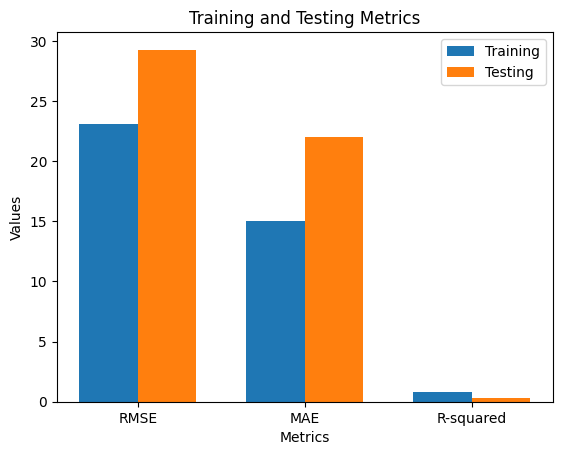

In [45]:
labels = ['RMSE', 'MAE', 'R-squared']
train_metrics = [train_rmse, train_mae, train_r2]
test_metrics = [test_rmse, test_mae, test_r2]
x = range(len(labels))
width = 0.35
fig, ax = plt.subplots()
train_rects = ax.bar(x, train_metrics, width, label='Training')
test_rects = ax.bar([i + width for i in x], test_metrics, width, label='Testing')
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Training and Testing Metrics')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()
plt.show()


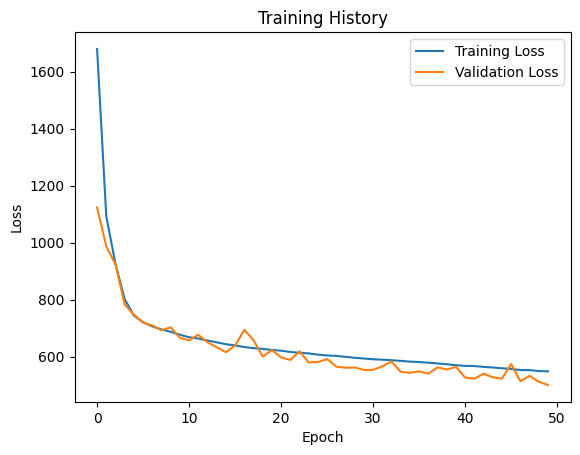

In [46]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()


# Using Complex Architecture

In [47]:
X_train = df_train1.drop(columns=['Sourcing Cost'])
y_train = df_train1['Sourcing Cost']

X_test = df_test1.drop(columns=['Sourcing Cost'])
y_test = df_test1['Sourcing Cost']

label_encoder = LabelEncoder()
categorical_cols = X_train.select_dtypes(include='object').columns

for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

    
X_train = X_train[:-2]
y_train = y_train[:-2]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout layer for regularization
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2946/2946 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1639.7932 - val_loss: 867.1601

Epoch 2/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 685.6358 - val_loss: 492.3551

Epoch 3/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 605.1808 - val_loss: 525.3394

Epoch 4/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 572.1940 - val_loss: 465.9082

Epoch 5/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 551.8027 - val_loss: 452.4879

Epoch 6/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 538.4454 - val_loss: 474.8983

Epoch 7/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 520.9185 - val_loss: 445.9904

Epoch 8/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 515.2643 - val_loss: 445.8372

Epoch 9/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 505.4631 - val_loss: 427.7528

Epoch 10/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 496.8281 - val_loss: 594.6756

Epoch 11/50

2946/2946 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 494

In [48]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("Training RMSE:", train_rmse)
print("Training MAE:", train_mae)
print("Training R-squared:", train_r2)
print("\nTest RMSE:", test_rmse)
print("Test MAE:", test_mae)
print("Test R-squared:", test_r2)

3682/3682 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Training RMSE: 20.923699844563732

Training MAE: 12.553419977230156

Training R-squared: 0.8148826770548319



Test RMSE: 30.760167287856127

Test MAE: 22.99340172064932

Test R-squared: 0.22094913146048356


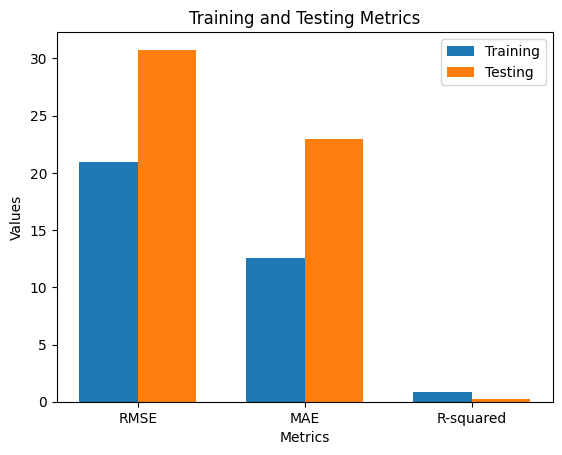

In [49]:
labels = ['RMSE', 'MAE', 'R-squared']
train_metrics = [train_rmse, train_mae, train_r2]
test_metrics = [test_rmse, test_mae, test_r2]
x = range(len(labels))
width = 0.35
fig, ax = plt.subplots()
train_rects = ax.bar(x, train_metrics, width, label='Training')
test_rects = ax.bar([i + width for i in x], test_metrics, width, label='Testing')
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Training and Testing Metrics')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()
plt.show()


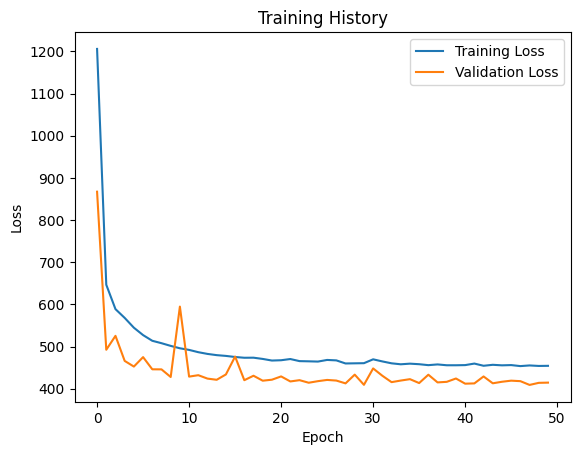

In [50]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()


### Conclusion:
Simple Architecture performs better and is approximately equivalent to that of XGBoost trained. Deeper architectures performs poor indicating understanding of data might not be as complex of a job for the neural entwork at the moment.

---
# arima 

In [51]:
auto_model = pm.auto_arima(df_train1['Sourcing Cost'], seasonal=False, trace=True)
best_params = auto_model.get_params()
print("Best Parameters:", best_params)

In [52]:
auto_model = pm.auto_arima(df_train1['Sourcing Cost'], seasonal=True, m=12, trace=True)

best_params = auto_model.get_params()
print("Best Parameters:", best_params)


### RAM insufficient error (I can go ahead and remove variables that are taking space but due to time constraint im going ahead but by using 'del' and the variable name i can free RAM and restart this cell which fits as a great alternative solution) 

*  ARIMA(1,0,0)(0,0,0)[12] intercept   As RAM keeps crashing for now we are taking this random values to see how well it model performs

In [53]:
# Fit the ARIMA model to the entire training data
order = (1, 0, 0)  # Non-seasonal parameters (p, d, q)
seasonal_order = (0, 0, 0, 12)  # Seasonal parameters (P, D, Q, S)
model = ARIMA(df_train1['Sourcing Cost'], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


                               SARIMAX Results                                


Dep. Variable:          Sourcing Cost   No. Observations:               117808

Model:                 ARIMA(1, 0, 0)   Log Likelihood             -623912.099

Date:                Sun, 12 May 2024   AIC                        1247830.199

Time:                        17:49:58   BIC                        1247859.229

Sample:                             0   HQIC                       1247838.944

                             - 117808                                         

Covariance Type:                  opg                                         


                 coef    std err          z      P>|z|      [0.025      0.975]

------------------------------------------------------------------------------

const         66.6646      0.177    377.291      0.000      66.318      67.011

ar.L1          0.1200      0.003     42.418      0.000       0.114       0.126

sigma2      2331.1935     11.946    19

In [54]:
y_pred_train = model_fit.predict(start=df_train1.index[0], end=df_train1.index[-1])

train_rmse = np.sqrt(mean_squared_error(df_train1['Sourcing Cost'], y_pred_train))
train_mae = mean_absolute_error(df_train1['Sourcing Cost'], y_pred_train)
train_r2 = r2_score(df_train1['Sourcing Cost'], y_pred_train)

print("Training RMSE:", train_rmse)
print("Training MAE:", train_mae)
print("Training R-squared:", train_r2)
print('')

y_pred_test = model_fit.forecast(steps=len(df_test1))

# Calculate metrics for testing dataset
test_rmse = np.sqrt(mean_squared_error(df_test1['Sourcing Cost'], y_pred_test))
test_mae = mean_absolute_error(df_test1['Sourcing Cost'], y_pred_test)
test_r2 = r2_score(df_test1['Sourcing Cost'], y_pred_test)

print("Testing RMSE:", test_rmse)
print("Testing MAE:", test_mae)
print("Testing R-squared:", test_r2)


Training RMSE: 48.282510526974484

Training MAE: 38.60120559321883

Training R-squared: 0.014397636139480419



Testing RMSE: 37.470747799376966

Testing MAE: 30.813001541584413

Testing R-squared: -0.15604077036442576


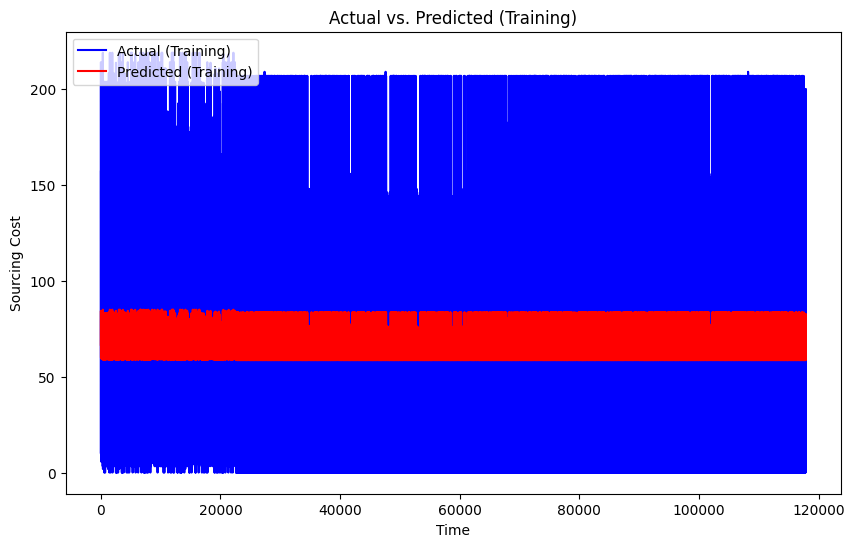

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(df_train1.index, df_train1['Sourcing Cost'], label='Actual (Training)', color='blue')
plt.plot(df_train1.index, y_pred_train, label='Predicted (Training)', color='red')
plt.xlabel('Time')
plt.ylabel('Sourcing Cost')
plt.title('Actual vs. Predicted (Training)')
plt.legend()
plt.show()


Overall we see ARIMA doesnt perform well based on RMSE , MAE AND R2 values 

In [56]:
# Define the SARIMA model parameters (p, d, q) and seasonal parameters (P, D, Q, S)
order = (1, 0, 0)  # Non-seasonal parameters (p, d, q)
seasonal_order = (0, 0, 0, 12)  # Seasonal parameters (P, D, Q, S)

model_sarima = SARIMAX(df_train1['Sourcing Cost'], order=order, seasonal_order=seasonal_order)
model_fit_sarima = model_sarima.fit()
print(model_fit_sarima.summary())

RUNNING THE L-BFGS-B CODE



           * * *



Machine precision = 2.220D-16

 N =            2     M =           10



At X0         0 variables are exactly at the bounds



At iterate    0    f=  5.50299D+00    |proj g|=  2.83613D-06



           * * *



Tit   = total number of iterations

Tnf   = total number of function evaluations

Tnint = total number of segments explored during Cauchy searches

Skip  = number of BFGS updates skipped

Nact  = number of active bounds at final generalized Cauchy point

Projg = norm of the final projected gradient

F     = final function value



           * * *



   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

    2      0      1      0     0     0   2.836D-06   5.503D+00

  F =   5.5029884141246326     



CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


                               SARIMAX Results                                


Dep. Variable:          Sourcing Cost   No. Observations:               117808

Model:               SARIMAX(1, 0, 0)   Log Likelihood             -648296.059

Date:                Sun, 12 May 2024   AIC                        1296596.118

Time:                        17:50:05   BIC                        1296615.472

Sample:                             0   HQIC                       1296601.949

                             - 117808                                         

Covariance Type:                  opg                                         


                 coef    std err          z      P>|z|      [0.025      0.975]

------------------------------------------------------------------------------

ar.L1          0.6943      0.002    315.971      0.000       0.690       0.699

sigma2      3526.6459     14.233    247.777      0.000    3498.749    3554.542


Ljung-Box (L1) (Q):               242

In [57]:
y_pred_train_sarima = model_fit_sarima.predict(start=df_train1.index[0], end=df_train1.index[-1])

train_rmse_sarima = np.sqrt(mean_squared_error(df_train1['Sourcing Cost'], y_pred_train_sarima))
train_mae_sarima = mean_absolute_error(df_train1['Sourcing Cost'], y_pred_train_sarima)
train_r2_sarima = r2_score(df_train1['Sourcing Cost'], y_pred_train_sarima)

print("Training RMSE (SARIMA):", train_rmse_sarima)
print("Training MAE (SARIMA):", train_mae_sarima)
print("Training R-squared (SARIMA):", train_r2_sarima)
print('')

y_pred_test_sarima = model_fit_sarima.forecast(steps=len(df_test1))

test_rmse_sarima = np.sqrt(mean_squared_error(df_test1['Sourcing Cost'], y_pred_test_sarima))
test_mae_sarima = mean_absolute_error(df_test1['Sourcing Cost'], y_pred_test_sarima)
test_r2_sarima = r2_score(df_test1['Sourcing Cost'], y_pred_test_sarima)

print("Testing RMSE (SARIMA):", test_rmse_sarima)
print("Testing MAE (SARIMA):", test_mae_sarima)
print("Testing R-squared (SARIMA):", test_r2_sarima)


Training RMSE (SARIMA): 59.385325361244895

Training MAE (SARIMA): 47.050907399949075

Training R-squared (SARIMA): -0.4910092205751282



Testing RMSE (SARIMA): 72.36624049671052

Testing MAE (SARIMA): 60.99692978805281

Testing R-squared (SARIMA): -3.3118183092956857


Again we see SARIMA Doesnt perform well

## Conclusion:
### XGBoost ≈ Neural Netowrk w/ simple architecture > Neural Netowrk w/ deeper architecture > ARIMA(Fine tuning required) > SARIMA (Fine tuning required)

---
## Future Directions and Improvements
In my analysis of time series forecasting using models like ARIMA, SARIMA, neural networks, and XGBoost, I've identified several areas for future exploration and improvement.

1. Feature Engineering:
Explore Additional Features: Investigate the incorporation of external factors such as economic indicators, weather data, or seasonal trends into the forecasting models to capture more comprehensive patterns in the data.
Transformations and Aggregations: Experiment with different transformations or aggregations of existing features to uncover more nuanced relationships and improve the predictive performance of the models.
2. Model Selection:
Advanced Models: Consider the adoption of more sophisticated time series forecasting models such as Prophet, LSTM (Long Short-Term Memory), or GRU (Gated Recurrent Unit) to better capture nonlinear relationships and long-term dependencies in the data.
Ensemble Methods: Explore ensemble techniques like stacking or blending to combine the predictions of multiple models (e.g., SARIMA, neural networks, XGBoost) and leverage their complementary strengths for improved forecasting accuracy.
3. Hyperparameter Tuning:
Thorough Parameter Search: Conduct a comprehensive hyperparameter search for each model to identify the optimal settings, including learning rate, number of layers, regularization, and other model-specific parameters.
SARIMA Parameter Exploration: Experiment with different combinations of SARIMA parameters (p, d, q) and seasonal parameters (P, D, Q, S) to identify the most effective configuration for capturing the underlying patterns in the data.
4. Model Evaluation:
Advanced Evaluation Metrics: Utilize specialized evaluation metrics tailored to time series forecasting tasks, such as Mean Absolute Scaled Error (MASE) or Symmetric Mean Absolute Percentage Error (SMAPE), to obtain more comprehensive insights into model performance.
Cross-Validation: Implement cross-validation techniques to assess the generalization ability of the models across different time periods and ensure robust performance estimates.
5. Data Preprocessing:
Robust Data Preprocessing: Apply robust preprocessing techniques such as outlier detection, missing value imputation, and normalization or standardization to enhance the quality and consistency of the input data.
6. Ensemble Learning:
Model Combination: Explore ensemble learning approaches to combine the predictions of multiple models, mitigating individual weaknesses and producing more reliable forecasts.
Why ARIMA and SARIMA Performed Less Effectively:
Linear Assumptions: ARIMA and SARIMA models assume linear relationships between input and output variables, which may limit their ability to capture complex nonlinear patterns in the data.
Stationarity Assumption: These models require stationarity in the data, which may not always hold true in real-world datasets with trends, seasonality, or other nonlinear patterns.
Flexibility of Neural Networks and XGBoost: Neural networks and XGBoost are more flexible and adept at learning complex nonlinear relationships and patterns from data. They can automatically extract features and dependencies, making them better suited for tasks where underlying relationships are nonlinear or not well understood.
By exploring these future avenues and improvements, we can potentially enhance the predictive performance of our time series forecasting models and obtain more accurate and reliable forecasts.

---
By Najeeb Fairuddin Saiyed

najeeb.saiyed.btech2021@sitpune.edu.in

+91 8128026682